In [142]:
from sklearn.datasets import load_digits
import numpy as np
digits = load_digits()

In [143]:
import math
import random

<Figure size 640x480 with 0 Axes>

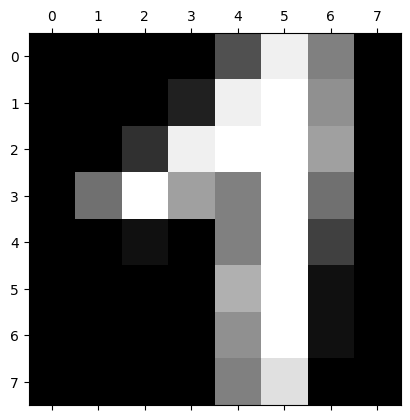

In [144]:
import matplotlib.pyplot as plt
plt.gray()

image_index = 131

digit_image = digits.images[image_index]

plt.matshow(digit_image)

In [145]:
def getAdjacentPixels(image_vector, digit_image_width, pixel_index):
    image_vector_len = len(image_vector)

    left_exists = pixel_index % digit_image_width != 0
    right_exists = pixel_index % digit_image_width != digit_image_width - 1 
    top_exists = pixel_index - digit_image_width >= 0
    bottom_exists = pixel_index + digit_image_width < image_vector_len

    top_neighbour_index = pixel_index - digit_image_width if top_exists else None
    bottom_neighbour_index = pixel_index + digit_image_width if bottom_exists else None
    left_neighbour_index = pixel_index - 1 if left_exists else None
    right_neighbour_index = pixel_index + 1 if right_exists else None

    top_right_neighbour_index = pixel_index - digit_image_width + 1 if top_exists and right_exists else None
    bottom_right_neighbour_index = pixel_index + digit_image_width + 1 if bottom_exists and right_exists else None
    bottom_left_neighbour_index = pixel_index + digit_image_width - 1 if bottom_exists and left_exists else None
    top_left_neighbour_index = pixel_index - digit_image_width - 1 if top_exists and left_exists else None

    
    return {
        "top": [top_neighbour_index, image_vector[top_neighbour_index] if top_neighbour_index is not None else None],
        "right": [right_neighbour_index, image_vector[right_neighbour_index] if right_neighbour_index is not None else None],
        "bottom": [bottom_neighbour_index, image_vector[bottom_neighbour_index] if bottom_neighbour_index is not None else None],
        "left": [left_neighbour_index, image_vector[left_neighbour_index] if left_neighbour_index is not None else None],
        "top_right": [top_right_neighbour_index, image_vector[top_right_neighbour_index] if top_right_neighbour_index is not None else None,],
        "bottom_right": [bottom_right_neighbour_index, image_vector[bottom_right_neighbour_index] if bottom_right_neighbour_index is not None else None,],
        "bottom_left": [bottom_left_neighbour_index, image_vector[bottom_left_neighbour_index] if bottom_left_neighbour_index is not None else None,],
        "top_left": [top_left_neighbour_index, image_vector[top_left_neighbour_index] if top_left_neighbour_index is not None else None],
    }

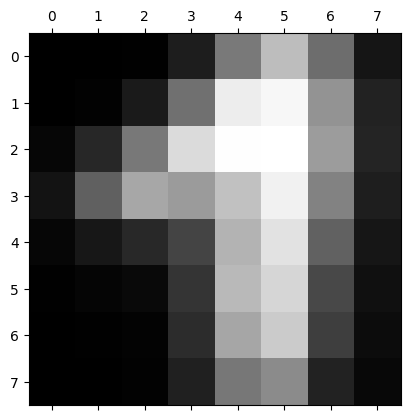

In [146]:
def gaussianFunction(x, y, sigma):
    return 1 / (2 * math.pi * sigma ** 2) * math.e ** (-(x**2 + y**2) / sigma ** 2)

def getGaussianKernel(size, sigma):
    if(size % 2 != 1):
        raise ValueError('kernel size should be odd')
 
    center_coord = math.floor(size / 2)
    kernel = [[gaussianFunction(x - center_coord, -y + center_coord, sigma) for x in range(size)] for y in range(size)]

    values_sum = sum(sum(row) for row in kernel)
    kernel_normalized = [[val / values_sum for val in row] for row in kernel]

    return np.array(kernel_normalized)

def applyGaussianBlur(image, kernel_size, sigma):
    blurred_image = image.copy()
    kernel = getGaussianKernel(kernel_size, sigma)
    kernel_x_max = kernel.shape[0] // 2
    kernel_y_max = kernel.shape[0] // 2
    y_max = blurred_image.shape[0]
    x_max = blurred_image.shape[1]
    
    for y, row in enumerate(image):
        for x, pixel in enumerate(row):
            pixel_sum = 0
            for y_kern, kernel_row in enumerate(kernel):
                for x_kern, kernel_cell in enumerate(kernel_row):
                    x_index = x + x_kern - kernel_x_max
                    y_index = y + y_kern - kernel_y_max
                    if(x_index < x_max and y_index < y_max and x_index >= 0 and y_index >= 0):
                        pixel_sum += blurred_image[y_index][x_index] * kernel[y_kern][x_kern]
            blurred_image[y, x] = pixel_sum

    return blurred_image
    
digit_image_blurred = applyGaussianBlur(digit_image, 3, 1)

plt.matshow(digit_image_blurred)


In [147]:
digit_image_blurred_vector = digit_image_blurred.flatten()
digit_image_original_shape = digit_image.shape
digit_image_width = digit_image.shape[1]
print(digit_image_width)

8


In [148]:
def getGradient(image_vector, digit_image_width):
    grad_vector = []
    for index, pixel_value in enumerate(image_vector):
        neighbours = getAdjacentPixels(image_vector, digit_image_width, index)
        top = neighbours["top"][1] or 0
        right = neighbours["right"][1] or 0
        bottom = neighbours["bottom"][1] or 0
        left = neighbours["left"][1] or 0
        vertical_grad_value = top - bottom
        horizontal_grad_value = right - left
        grad_vector.append([vertical_grad_value, horizontal_grad_value])
        
    return grad_vector

gradient_vector = getGradient(digit_image_blurred_vector, digit_image_width)

In [149]:
gradient_props = list(map(lambda grad: [math.sqrt(grad[0]**2 + grad[1]**2), math.atan2(grad[0], grad[1])], gradient_vector))

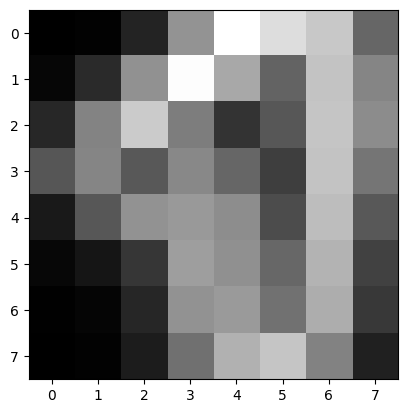

In [150]:
gradient_magnitude_image = np.array([prop[0] for prop in gradient_props]).reshape(digit_image_original_shape)
plt.imshow(gradient_magnitude_image, cmap='gray')
plt.show()

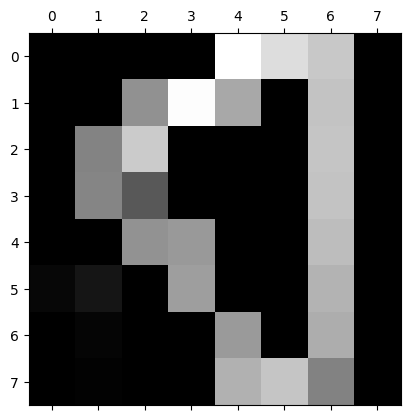

In [151]:
def applyNonMaximumSuppression(gradient_props, digit_image_width):
    suppressed_non_maximum_gradient_vector = gradient_props.copy()
    for index, gradient_prop in enumerate(gradient_props):
        neighbours = getAdjacentPixels(gradient_props, digit_image_width, index)

        top = neighbours["top"]
        right = neighbours["right"]
        bottom = neighbours["bottom"]
        left = neighbours["left"]
        top_right = neighbours["top_right"]
        bottom_right = neighbours["bottom_right"]
        bottom_left = neighbours["bottom_left"]
        top_left = neighbours["top_left"]

        gradient_angle_deg = gradient_prop[1] * 180 / math.pi
        comparison_pixels = [None, None]

        if (-22.5 <= gradient_angle_deg <= 22.5 or gradient_angle_deg >= 157.5 or gradient_angle_deg <= -157.5 ):
            comparison_pixels = [left, right]
        elif (67.5 <= gradient_angle_deg <= 112.5 or -112.5 <= gradient_angle_deg <= -67.5):
            comparison_pixels = [top, bottom]
        elif (22.5 <= gradient_angle_deg <= 67.5 or -157.5 <= gradient_angle_deg <= -112.5):
            comparison_pixels = [top_right, bottom_left]
        elif (112.5 <= gradient_angle_deg <= 157.5 or -67.5 <= gradient_angle_deg <= -22.5):
            comparison_pixels = [top_left, bottom_right]
        else:
            raise(ValueError('Pixels not found for degree: ' + str(gradient_angle_deg)))
        
        comparison_pixel_values = [
            comparison_pixels[0][1][0] if comparison_pixels[0][0] is not None else 0,
            comparison_pixels[1][1][0] if comparison_pixels[1][0] is not None else 0,
        ]
        if (gradient_prop[0] < comparison_pixel_values[0] or gradient_prop[0] < comparison_pixel_values[1]):
            suppressed_non_maximum_gradient_vector[index][0] = 0
    return suppressed_non_maximum_gradient_vector


suppressed_non_maximum_gradient_vector = applyNonMaximumSuppression(gradient_props, digit_image_width)

plt.matshow(np.array(list(map(lambda x: x[0], suppressed_non_maximum_gradient_vector))).reshape([digit_image_width,digit_image_width]))



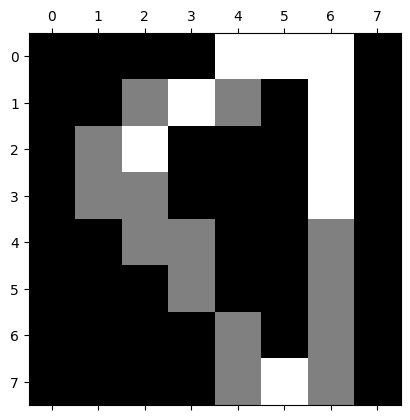

In [152]:
def applyDoubleThresholding(gradient_vector):
    gradient_magnitudes_vector = [x[0] for x in gradient_vector]
    max_grad_magnitude = max(gradient_magnitudes_vector)
    high_threshold = math.floor(0.8 * max_grad_magnitude)
    low_threshold = math.ceil(0.2 * max_grad_magnitude)
    
    return list(map(lambda x: [ 255 if x[0] > high_threshold else 128 if x[0] > low_threshold else 0, x[1]], gradient_vector))

thresholded_gradient_vector = applyDoubleThresholding(suppressed_non_maximum_gradient_vector)
plt.matshow(np.array(list(map(lambda x: x[0], thresholded_gradient_vector))).reshape([digit_image_width,digit_image_width]))

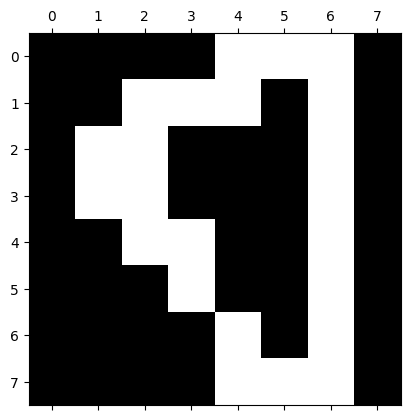

In [153]:
def get_has_high_threshold_neighbours(vector, index, original_width):
    neighbours = getAdjacentPixels(vector, digit_image_width, index)

    return any(False if direction[1] is None else direction[1][0] == 255 for direction in neighbours.values())

def apply_hysteresis_edge_tracking(gradient_vector, original_width):
    gradient_copy = gradient_vector.copy()
    has_promotable_weak_edge_pixels = True

    while(has_promotable_weak_edge_pixels):
        gradient_magnitudes_vector = [x[0] for x in gradient_copy]
        promotable_weak_edge_pixel_indices = [
            i for i, x in enumerate(gradient_magnitudes_vector)
            if x == 128 and get_has_high_threshold_neighbours(gradient_vector, i, original_width)
        ]
        has_promotable_weak_edge_pixels = len(promotable_weak_edge_pixel_indices) > 0
        for i in promotable_weak_edge_pixel_indices:
            gradient_copy[i][0] = 255

    return gradient_copy

preprocessed_image_vector = apply_hysteresis_edge_tracking(thresholded_gradient_vector, digit_image_width)

plt.matshow(np.array(list(map(lambda x: x[0], preprocessed_image_vector))).reshape([digit_image_width,digit_image_width]))

In [154]:
# input layer

image_pixel_intensities = np.array(preprocessed_image_vector)[:, 0]
x = [1 if x > 0 else 0 for x in image_pixel_intensities]


In [155]:
def get_he_normal_weights(n_in, n_out):
    return np.array([random.gauss(0, (2 / n_in) ** 0.5) for x in range(n_in * n_out)]).reshape(n_out, n_in)

def re_lu(z):
    return [x if x > 0 else 0 for x in z]

def re_lu_derivative(z):
    return [1 if x > 0 else 0 for x in z]

def softmax(a):
    return np.array([
        math.e ** xi / sum([math.e ** xj for xj in a])
        for xi
        in a
    ])

In [156]:
# hidden layer
a1 = np.array(a0)
n1_in = len(a1)
n1_out = 32 # arbitrary hyperparameter
w1 = np.array(get_he_normal_weights(n1_in, n1_out))
b1 = [0.1 for x in range(n1_out)]

z1 = np.dot(w1, a1) + b1
a2 = re_lu(z1)

In [157]:
# output layer
a2 = np.array(a2)
n2_in = len(a2)
n2_out = 10 # corresponding to 10 digits
w2 = np.array(get_he_normal_weights(n2_in, n2_out))
b2 = [0.1 for x in range(n2_out)]

z2 = np.dot(w2, a2) + b2
correct_image_index = image_index % 10

yhat = softmax(z2)
y = np.array([1 if correct_image_index - 1 == x else 0  for x in range(10)])

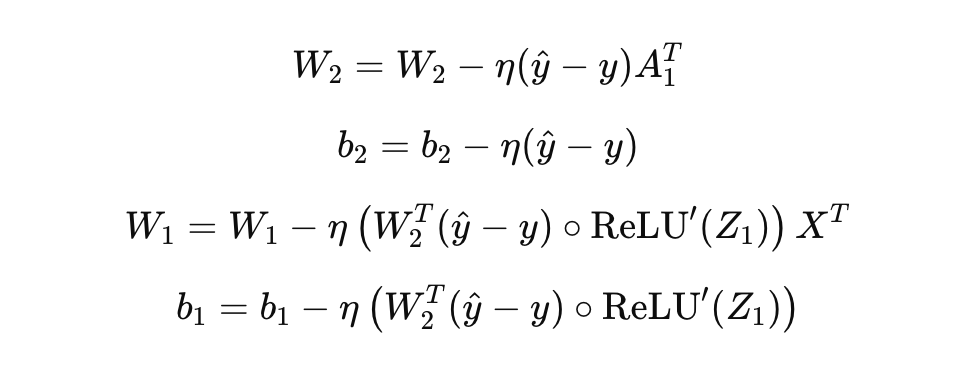

In [170]:
n = 0.01 # learning rate


def adjust_w2(w2, n, yhat, y, a1):
    term1 = (yhat - y).reshape(10, 1)
    term2 = np.transpose(a1).reshape(1, 64)
    sub = n * np.dot(term1, term2)
    return w2 - sub

def adjust_b2(b2, n, yhat, y):
    return b2 - n * (yhat - y)

def adjust_w1(w1, w2, n, yhat, y, z1, x):
    dotproduct = np.dot(w2.transpose().reshape(32, 10), yhat - y)
    term1 = n * (dotproduct * re_lu_derivative(z1))
    return w1 - np.dot(term1, x.transpose())

def adjust_b1(b1, n, w2, yhat, y, z1):
    return b1 - np.dot(n * (np.dot(w2.transpose(), yhat - y) * re_lu_derivative(z1)))

ww2 = adjust_w2(w2, n, yhat, y, a1)
# bb2 = adjust_b2(b2, n, yhat, y)
a1.shape
# ww1 = adjust_w1(w1, w2, n, yhat, y, z1, x)
# bb1 = adjust_b1(b1, w2, n, yhat, y, z1)


ValueError: operands could not be broadcast together with shapes (10,32) (10,64) 